In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

import sys
sys.path.append('../src')
sys.path.append('../.env')

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [120]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 30  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

# 1. Loading from a _long_ DataFrame


In [121]:
# Load dataframe
url = (
    'dataset.csv'
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

df.head()

,dwn,upl
day,,
2023-03-07,245052.357517,24155.163205
2023-03-08,240602.348840,23944.385604
2023-03-09,255954.226283,24774.163707
2023-03-10,270973.305303,25705.713906
2023-03-11,256827.326335,24914.988007


In [122]:
# Add an item_id column with a default value
df['item_id'] = 'A'
df.head()


,dwn,upl,item_id
day,,,
2023-03-07,245052.357517,24155.163205,A
2023-03-08,240602.348840,23944.385604,A
2023-03-09,255954.226283,24774.163707,A
2023-03-10,270973.305303,25705.713906,A
2023-03-11,256827.326335,24914.988007,A


In [123]:
# Convert into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="dwn", item_id="item_id")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [124]:
# Prepare model
model = MoiraiForecast.load_from_checkpoint(
    checkpoint_path=hf_hub_download(
        repo_id=f"Salesforce/moirai-1.0-R-{SIZE}", filename="model.ckpt"
    ),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    map_location="cuda:0" if torch.cuda.is_available() else "cpu",
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

AttributeError: 'Axes' object has no attribute 'flat'

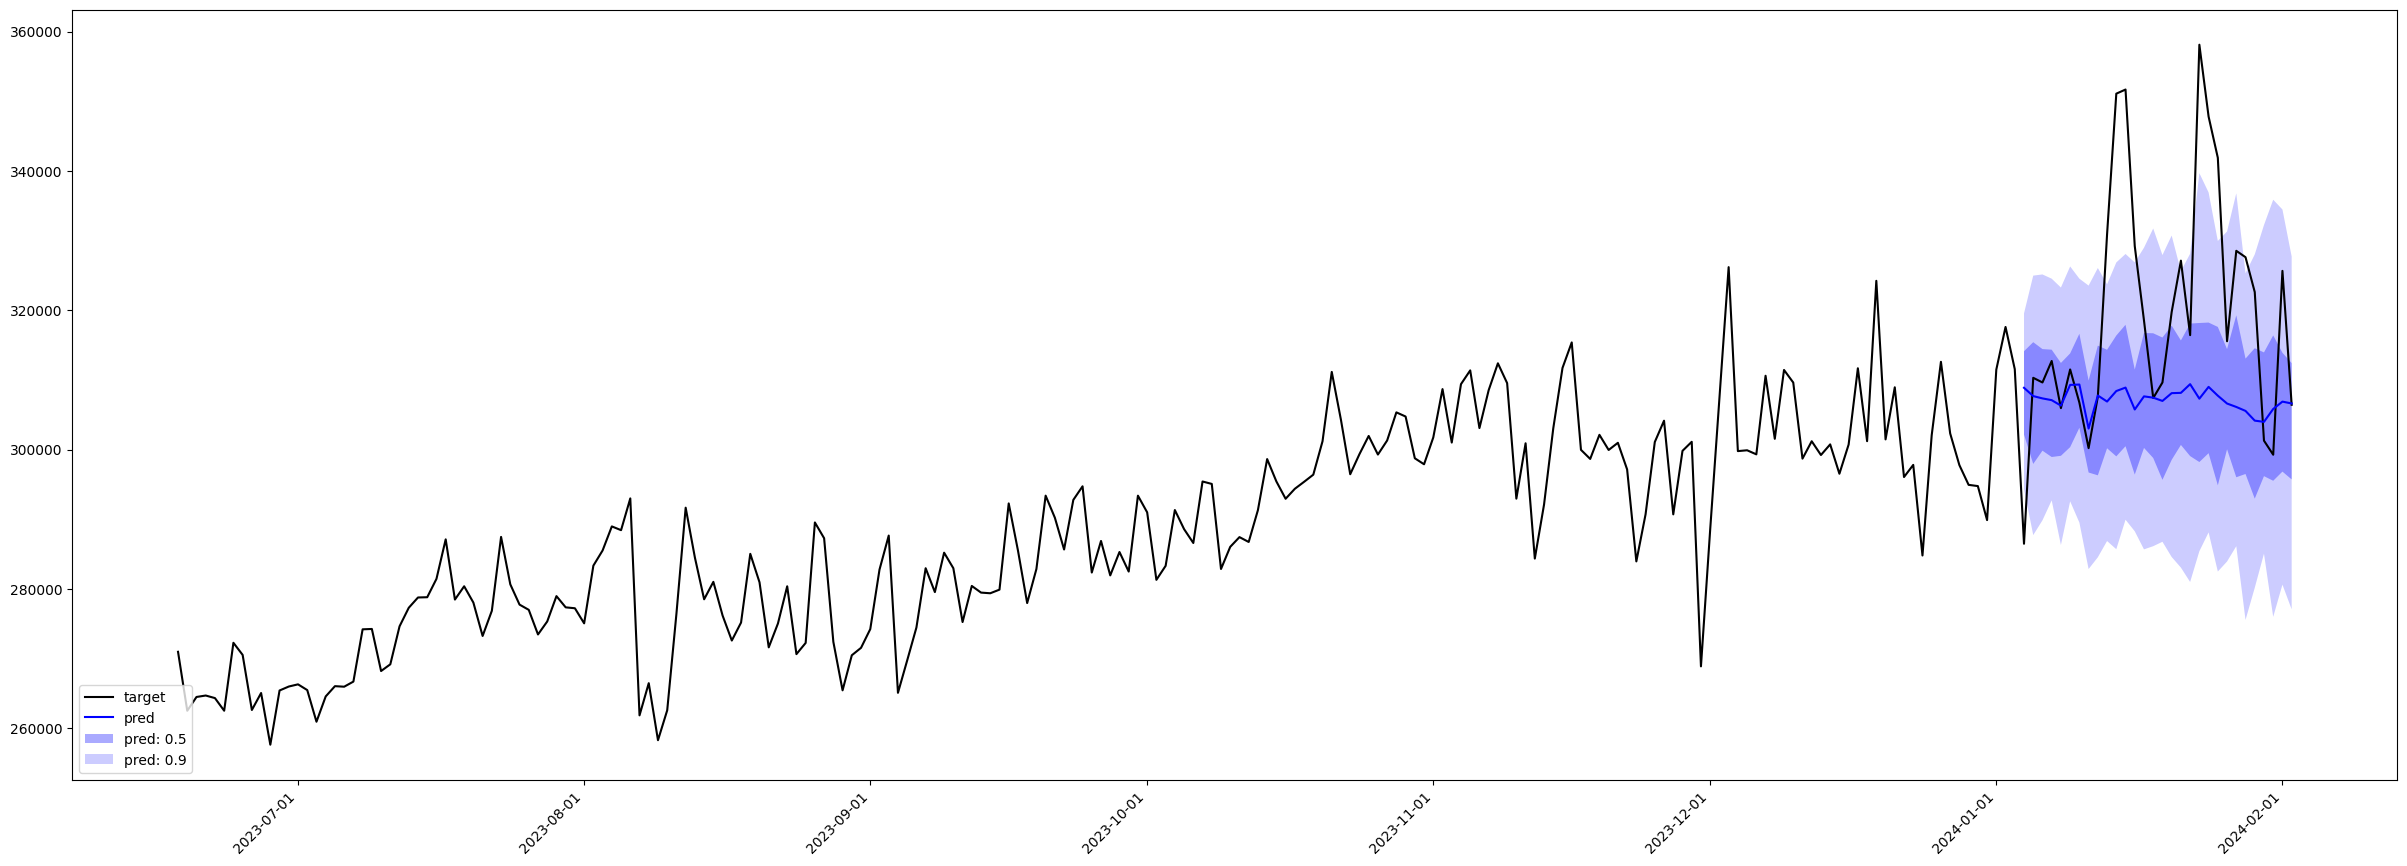

In [125]:
# Make predictions
# Adjust the figsize to make the plots bigger
#fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(30, 50))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 10))

# Make predictions and plot
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# Adjust the fontsize of ticks and labels
for ax in axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()